In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov
from scipy.io import loadmat
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline
#%matplotlib notebook

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'newFigures/'

I'm starting to wonder that all of the mess is because of the transformation I define from velocity vorticity. 

In JB05 (Jovanovic & Bamieh, 2005, Componentwise energy...), eq. A.1, they define an operator 
$$ \mathcal{L} = \frac{1}{k^2_x + k^2_z} \begin{bmatrix} -\Delta & 0 \\ 0 & I \end{bmatrix} $$
and say that the energy norm is
$$ E = \big< \psi , \psi \big>_e = \frac{1}{8} \int\limits_{-1}^1 \psi^* \mathcal{L} \psi  dy = \big< \psi, \mathcal{L} \psi \big> $$

The counterpart for this definition in CoT is eq. A.1, which uses $Q$ instead of $\mathcal{L}$. The state-transformation is given as $\psi = Q^{1/2} \phi$. I couldn't convince myself that the above definition of $\mathcal{L}$ produces an appropriate norm, so I ended up using my own definition, 
$$C_\phi^* I_w C_\phi = Q$$

This hasn't done so well so far. So, I guess I'll just have to see where using JB05's definition takes me.

In [191]:
a0 = 0.25; b0 = 2./3.; l = 10; m = 10; N = 127; Re = 186.
a = l*a0; b = m*b0
b = 7.
k2 = a**2 + b**2
Z1 = np.zeros((N,N), dtype=np.complex)
I1 = np.identity(1*N, dtype=np.complex)
I2 = np.identity(2*N, dtype=np.complex)
I3 = np.identity(3*N, dtype=np.complex)

weightDict = pseudo.weightMats(N=N)
W2  = weightDict['W2']
W3  = weightDict['W3']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']

statInst = ops.statComp(N=N, Re=Re, a=a,b=b,covMat = I3)
statInst.U = (18.25/18.)* statInst.U;
statInst.dU = (18.25/18.)* statInst.dU;
statInst.d2U = (18.25/18.)* statInst.d2U;
statInst.nu = np.ones(N)

Cphi = statInst.velVor2primitivesMat()

Delta = statInst.D2 - k2 * I1
Q = (1./k2) * np.vstack((   np.hstack(( -Delta, Z1)), 
                            np.hstack(( Z1,  I1))    ))
#Q = Cphi.conj().T @ W3 @Cphi

Q = (W2) @ Q
#Qs = W2s @ sqrtm(Q)
Qs = sqrtm(Q)
#Qs = sqrtm(Q) @ W2s
Qsi= np.linalg.solve(Qs, I2)


Aphi = statInst.dynamicsMat()
Cphi = statInst.velVor2primitivesMat()
Bphi = statInst.primitives2velVorMat(custom=False)
Apsi = Qs @ Aphi @ Qsi
Bpsi = Qs @ Bphi @ W3si
Cpsi = W3s@ Cphi @ Qsi

matDict = loadmat('data_figure9_jfm17.mat') # Data set from Zare
Am = matDict['A']; Cm = matDict['L']; Bm = Cm.conj().T





Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 8.1.1.
New in this version: Eddy viscosity fixed
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 7.0 186.0


/home/svadarevu/gitwork/linear/library/ops.py:190: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  # Where dot products are needed, use np.dot(A,B) instead of A*B
/home/svadarevu/gitwork/linear/library/ops.py:230: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  


0.385921373744 0.143207950894 0.0535719451225 246524.02264 279634.702597


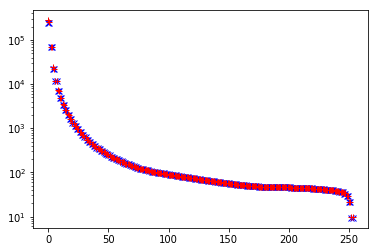

In [192]:
diffNorm = lambda mat1,mat2: np.linalg.norm(mat1-mat2, ord='fro')/np.linalg.norm(mat1,ord='fro')

A = Apsi; B = Bpsi; C = Cpsi

Adiff = diffNorm(A,Am)
Bdiff = diffNorm(B,Bm)
Cdiff = diffNorm(C,Cm)

U,S,V = np.linalg.svd(A); Um,Sm,Vm = np.linalg.svd(Am)
print(Adiff, Bdiff,Cdiff, np.linalg.norm(A,ord=2), np.linalg.norm(Am,ord=2))
#%matplotlib notebook
%matplotlib inline
plt.figure()
plt.plot(S,'bx')
plt.plot(Sm,'r+')
plt.yscale("log")
plt.show()



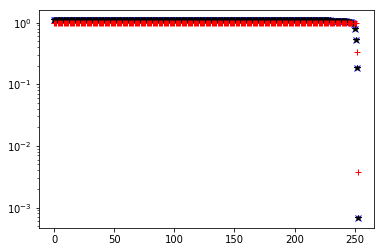

In [188]:
U,S,V = np.linalg.svd(Cpsi.conj().T @Cpsi)
U,Sb,V = np.linalg.svd(Bpsi @Cpsi)
U,Sm,V = np.linalg.svd(Bm @ Cm)
plt.figure()
plt.plot(S,'bx')
plt.plot(S,'k*')
plt.plot(Sm,'r+')
plt.yscale("log")
plt.show()

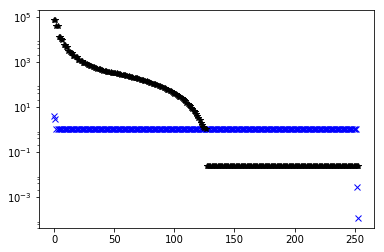

In [136]:
U,S,V = np.linalg.svd(Bphi@Cphi)
U,Sb,V = np.linalg.svd(Cphi.conj().T @ Cphi)

plt.figure()
plt.plot(S,'bx')
plt.plot(Sb,'k*')
plt.yscale("log")
plt.show()

In [87]:
S[:5]

array([ 1.,  1.,  1.,  1.,  1.])

In [174]:
N = 127; Re=186.; a=2.5; b=20./3.
statInst = ops.statComp(N=N,Re=Re, a=a,b=b)
Qs = statInst.stateTrans()
Aphi = statInst.dynamicsMat()
Cphi = statInst.outputMat()
Bphi = statInst.primitives2velVorMat(a=a,b=b)

Using parameters Re=186, alfa=46.5, kapa=0.61, N=127
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
covMat was not supplied. Loading matrix from /mnt/kepler/sabarish/data/R186/covN127/covR186N127l10m10.npy ...
covMat from DNS data has y as spanwise. Reordering to have y as wall-normal......
Reordering complete... Remember to verify the ordering.
Remember that the covariance matrix is defined on clencurt-weighted velocity fields.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 2.5 6.666666666666667 186.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


In [181]:
y = statInst.y.copy()
weightDict = pseudo.weightMats(N=N)
w2 = np.diag(weightDict['W2']); w3 = np.diag(weightDict['W3'])
uvw =np.concatenate(( (1.-y**2)/a, 0.*y, -(1.-y**2)/b    ))
phi = Bphi @ uvw
psi = Qs @ phi
uvw0 = Cphi @ phi

print(w3 @ (uvw*uvw), psi @ psi.conj(),  np.linalg.norm(uvw-uvw0)  )


eta1 = (np.sin(np.pi*y))**2
eta2 = np.sin(np.pi*y) + (1. - y**2)**3
v1 =  -3.*np.sin(np.pi*y) + np.sin(3.*np.pi*y)
v2 = 2.*(1. - y**2) - (1. - y**4)
uvw1 = Cphi @ np.concatenate((v1,eta1))
uvw2 = Cphi @ np.concatenate((v2,eta2))
psi1 = Qs @ np.concatenate((v1,eta1))
psi2 = Qs @ np.concatenate((v2,eta2))


print(w3 @ (uvw1*uvw1), psi1 @ psi1.conj())
print(w3 @ (uvw2*uvw2), psi2 @ psi2.conj())


0.0973333333333 (0.0973333333333+0j) 1.91003744204e-15
(3.24040995838+0j) (6.75959004161+0j)
(0.365712801658+0j) (0.44698561104+0j)


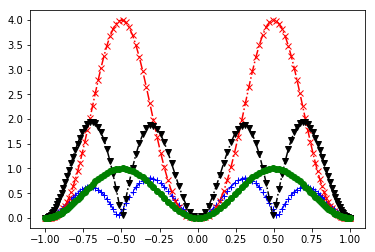

In [182]:
plt.plot(y, np.abs(uvw1[:N]),'b+-.')
plt.plot(y, np.abs(uvw1[N:2*N]), 'rx-.')
plt.plot(y, np.abs(uvw1[2*N:3*N]), 'kv-.')
plt.plot(y, np.abs(eta1[:]), 'go-.')

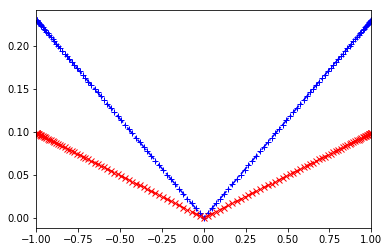

In [179]:
y = statInst.y.copy()
v3 = 1.-y**2
eta3 = y.copy()
uvw3 = Cphi @ np.concatenate(( v3,eta3 ))
plt.plot(y, np.abs(uvw3[:N]),'b+-.')
eta3[:] = 0.
uvw3 = Cphi @ np.concatenate(( v3,eta3 ))
plt.plot(y, np.abs(uvw3[:N]),'rx-.')
plt.xlim([-1.,1.])
plt.show()

In [166]:
uvw3[:N].shape, Cphi.shape, np.concatenate((v3,eta3)).shape, y.shape

((127,), (381, 254), (254,), (127,))

In [173]:
statInst.y

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])